In [38]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the environment variable
together_api = os.environ.get('TOGETHER_API_KEY')

In [39]:
from langchain_openai import ChatOpenAI

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"

llm = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=together_api
)

In [40]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("You are a helpful assistant AI assistant."),
    HumanMessage("Hello, I am Amir. Who are you?"),
]

response = llm.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

Hello Amir, I'm an AI assistant, and I'm here to help you with any questions or tasks you may have. I don't have a personal name, but you can think of me as a helpful companion who can provide information, answer questions, and assist with a wide range of topics. How can I assist you today?


In [41]:
from typing import TypedDict, Optional

class MyState(TypedDict):
    user_query: str
    rewritten_query: Optional[str]
    need_internet_search: Optional[bool]
    search_results: Optional[str]
    final_answer: Optional[str]

In [42]:
def node_query_rewrite(state: MyState) -> MyState:
    """
    Rewrites the user's query using an LLM for clarity or correctness.
    """
    print("---Node Query Rewrite---")
    user_query = state["user_query"]
    
    rewrite_prompt = f"Please rewrite this query suitable for search engines:\n\n{user_query}"
    # Invoke the LLM to rewrite the query
    rewritten = llm.invoke(rewrite_prompt).content
    print("Rewritten query:", rewritten)
    state["rewritten_query"] = rewritten
    return state

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
import nest_asyncio
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import pandas as pd

nest_asyncio.apply()
db = lancedb.connect(".lancedb")
pdf_files = ["../assets/The New Complete Book of Foos.pdf"]
llama_pase_api = os.environ.get("LLAMA_PARSE_API_KEY")

parser = LlamaParse(result_type="text", api_key=llama_pase_api)
file_extractor = {".pdf": parser}
data_for_parse = SimpleDirectoryReader(input_files=pdf_files, file_extractor=file_extractor)
documents =data_for_parse.load_data()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

documents_list = []
page_number = 0
last_doc = None
for doc in documents:
    if last_doc is None or last_doc != doc.metadata["file_name"]:
        page_number = 1
        last_doc = doc.metadata["file_name"]
    else:
        page_number += 1

    texts = text_splitter.split_text(doc.text)
    for text in texts:
        item = {}
        item["id_"] = doc.id_
        item["text"] = text
        item["metadata_file_name"] = doc.metadata["file_name"]
        item["metadata_creation_date"] = doc.metadata["creation_date"]
        item["metadata_pagenumber"] = page_number
        documents_list.append(item)


embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5", device="mps")

class ChunksOfData(LanceModel):
    text: str = embedding_model.SourceField()
    metadata_file_name: str
    metadata_creation_date: str
    metadata_pagenumber: int
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField() # type: ignore
    
    
df = pd.DataFrame(documents_list)

def df_to_dict_batches(df: pd.DataFrame, batch_size: int = 128):
    """
    Yields data from a DataFrame in batches of dictionaries.
    Each batch is a list of dict, suitable for LanceDB ingestion.
    """
    for start_idx in range(0, len(df), batch_size):
        end_idx = start_idx + batch_size
        # Convert the batch of rows to a list of dict
        batch_dicts = df.iloc[start_idx:end_idx].to_dict(orient="records")
        yield batch_dicts

tbl = db.create_table(
    "embedded_chunks3",
    data=df_to_dict_batches(df, batch_size=10),
    schema=ChunksOfData,
)

In [47]:
def node_search_book(state: MyState) -> MyState:
    """
    search from the book
    """
    query = state["rewritten_query"]
    
    context_list = tbl.search(query, query_type="hybrid").limit(5).to_list()
    context = ''.join([f"{c['text']}\n\n" for c in context_list])
    
    system_prompt = "Answer user query based on the given context.if context is not related, just write: unrelated"
    user_prompt = f"Question:\n{query}\nContext:\n{context}"

    messages = [
        SystemMessage(system_prompt),
        HumanMessage(user_prompt),
    ]
    
    results = llm.invoke(messages)
    if results == "unrelated":
        state["need_internet_search"] = True
    else:
        state['search_results'] = results
    
    return state

In [43]:
from langchain_community.tools.tavily_search import TavilySearchResults

def node_search_internet(state: MyState) -> MyState:
    """
    Searches the internet for the rewritten query using a search tool.
    """
    if state["need_internet_search"]:
        print("---Node Search Internet---")
        rewritten_query = state["rewritten_query"]
    
        # Use your search tool function
        results = TavilySearchResults(max_results=3).invoke(rewritten_query)
        print("Search results:")
        print(results)
        # Save the search results in state
        state["search_results"] = str(results)
        
    return state

In [44]:
def node_generate_answer(state: MyState) -> MyState:
    """
    Generates a final answer based on the original user query and the search results.
    """
    print("---Node Generate Answer---")
    user_query = state["user_query"]
    search_info = state["search_results"] or "No search results found."
    
    # Combine user query with search results to generate answer
    final_answer = llm.invoke(
        f"User's query: {user_query}\n\nSearch results:\n{search_info}\n\n"
        "Please provide a helpful answer."
    )
    print("Final answer:", final_answer.content)
    state["final_answer"] = final_answer.content
    return state

In [45]:
from pydantic import BaseModel, Field

class IsRelated(BaseModel):
    reasoning : str = Field(description="The reasoning behind the decision, wheather it is the query is related to restaurants and foods or not.")
    is_related_flag: bool = Field(description="The decision whether the query is related to restaurants and foods or not.")

In [46]:
from typing import Literal

def is_related(MyState) -> Literal["node_query_rewrite", "node_generate_answer"]:
    query = MyState["user_query"]
    llm_with_structured_output = llm.with_structured_output(IsRelated)
    response = llm_with_structured_output.invoke(query)
    print("-----Is Related-----")
    print(response)
    if response.is_related_flag == True:
        return "node_query_rewrite"
    else:
        return "node_generate_answer"

In [48]:
from langgraph.graph import StateGraph, START, END

# Build the graph
builder = StateGraph(MyState)

# Add nodes
builder.add_node("node_query_rewrite", node_query_rewrite)
builder.add_node("node_search_book", node_search_book)
builder.add_node("node_search_internet", node_search_internet)
builder.add_node("node_generate_answer", node_generate_answer)

# Add edges (linear flow)
builder.add_conditional_edges(START, is_related)

builder.add_edge("node_query_rewrite", "node_search_book")
builder.add_edge("node_search_book", "node_search_internet")
builder.add_edge("node_search_internet", "node_generate_answer")
builder.add_edge("node_generate_answer", END)

# Compile the graph
advanced_search_graph = builder.compile()

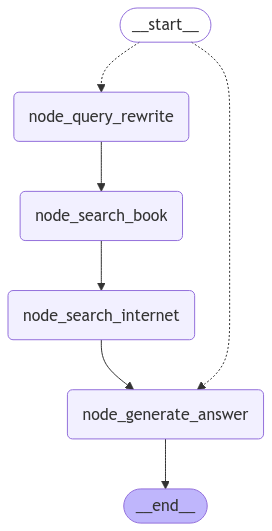

In [49]:
from IPython.display import Image, display

display(Image(advanced_search_graph.get_graph().draw_mermaid_png()))